###  Step 1: Setup for Content-Based Filtering (CBF)

In [23]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import random


### Step 2: Feature Engineering
Recipes are represented in a similarity space built from their ingredient lists.
Ingredients are treated as textual features and vectorized with TF-IDF.
This does not recommend ingredients directly — it uses them as features to compute recipe–recipe similarity.


In [24]:
# Load the dataset
recipes_df = pd.read_csv("data/recipes/RAW_recipes.csv")

print(f"Loaded {len(recipes_df)} recipes")
print("Columns:", recipes_df.columns.tolist())

recipes_df[['id', 'name', 'ingredients']].head(3)


Loaded 231637 recipes
Columns: ['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients']


,id,name,ingredients
0,137739,arriba baked winter squash mexican style,"['winter squash', 'mexican seasoning', 'mixed ..."
1,31490,a bit different breakfast pizza,"['prepared pizza crust', 'sausage patty', 'egg..."
2,112140,all in the kitchen chili,"['ground beef', 'yellow onions', 'diced tomato..."


###  Step 3: Preprocess Ingredients and Build TF-IDF Matrix

In [25]:
from ast import literal_eval

# Convert stringified ingredient lists into plain text
recipes_df['ingredients'] = recipes_df['ingredients'].apply(literal_eval)
recipes_df['ingredient_text'] = recipes_df['ingredients'].apply(lambda ing: ' '.join(ing))

# Build TF-IDF vectors
tfidf = TfidfVectorizer(stop_words='english')
ingredient_matrix = tfidf.fit_transform(recipes_df['ingredient_text'])

print(f"Vectorized {ingredient_matrix.shape[0]} recipes with {ingredient_matrix.shape[1]} unique terms.")


Vectorized 231637 recipes with 4158 unique terms.


### Step 4: Recommendation Generation
Generate recipe recommendations for each user by comparing their profile
(average of liked recipe vectors) against all other recipes in the catalogue.
Recommendations are other **recipes** most similar in ingredient composition.


In [26]:
def recommend_similar(recipe_id, top_k=5):
    idx_list = recipes_df.index[recipes_df['id'] == recipe_id].tolist()
    if not idx_list:
        print("Recipe ID not found.")
        return []
    idx = idx_list[0]

    sim_scores = cosine_similarity(ingredient_matrix[idx], ingredient_matrix).flatten()

    # Exclude the recipe itself
    sim_scores[idx] = -1
    top_indices = sim_scores.argsort()[::-1][:top_k]

    return recipes_df.iloc[top_indices]['id'].tolist()


###  Simulate User Profiles (Dynamic)

In [27]:
# Create N simulated users with random liked items
n_users = 5
simulated_users = {
    f"user_{i+1}": recipes_df['id'].sample(3).tolist()
    for i in range(n_users)
}
simulated_users


{'user_1': [42427, 366083, 25276],
 'user_2': [476873, 222560, 266984],
 'user_3': [4491, 384090, 457392],
 'user_4': [277271, 162111, 283929],
 'user_5': [446684, 8109, 291251]}

###  Step 6: Generate Recommendations for Users

In [29]:
recommendations = {}
all_recs = set()

for user, liked_ids in simulated_users.items():
    liked_indices = [recipes_df.index[recipes_df['id'] == rid].tolist()[0] for rid in liked_ids if rid in recipes_df['id'].values]
    profile_vector = ingredient_matrix[liked_indices].mean(axis=0)
    profile_vector = np.asarray(profile_vector)

    sim_scores = cosine_similarity(profile_vector, ingredient_matrix).flatten()
    mask = [rid not in liked_ids for rid in recipes_df['id']]
    sim_scores = np.where(mask, sim_scores, -1)

    top_indices = sim_scores.argsort()[-5:][::-1]
    recs = recipes_df.iloc[top_indices]['id'].tolist()

    recommendations[user] = recs
    all_recs.update(recs)

print(" Recommendations generated for all users")


 Recommendations generated for all users


## Step 7: Catalog Coverage (Dynamic)

In [30]:
all_items = set(recipes_df['id'])
coverage = len(all_recs) / len(all_items)
print(f"Catalog Coverage: {coverage:.2%}")


Catalog Coverage: 0.01%


### Step 8: Redundancy in Recommendations (Dynamic)

In [32]:
from collections import Counter

all_recs_list = [item for recs in recommendations.values() for item in recs]
item_counts = Counter(all_recs_list)

redundant_items = [item for item, count in item_counts.items() if count > 1]
redundancy_rate = len(redundant_items) / len(all_recs_list) if all_recs_list else 0.0

print(f"Redundancy rate: {redundancy_rate:.2%}")
print(f"Repeated items across users: {len(redundant_items)}")


Redundancy rate: 0.00%
Repeated items across users: 0


### Step 9: Intra-List Similarity (Diversity)

In [36]:
def compute_intra_list_similarity(user_recs, item_vectors, id_to_index):
    similarities = []
    for user, recs in user_recs.items():
        valid_indices = [id_to_index[r] for r in recs if r in id_to_index]
        if len(valid_indices) > 1:
            rec_vectors = item_vectors[valid_indices].toarray()
            sim_matrix = cosine_similarity(rec_vectors)
            n = len(valid_indices)
            sims = sim_matrix[np.triu_indices(n, k=1)]
            if sims.size > 0:
                similarities.append(sims.mean())
    return np.mean(similarities) if similarities else 0.0

# Build mapping for recipe IDs
id_to_index = {rid: idx for idx, rid in enumerate(recipes_df['id'])}

intra_similarity = compute_intra_list_similarity(recommendations, ingredient_matrix, id_to_index)
diversity = 1 - intra_similarity

print(f"Intra-list similarity: {intra_similarity:.2f}")
print(f"Diversity (1 - Intra-sim): {diversity:.2f}")


Intra-list similarity: 0.56
Diversity (1 - Intra-sim): 0.44


### Step 10: Profile-to-Item Similarity (Overfitting Check)

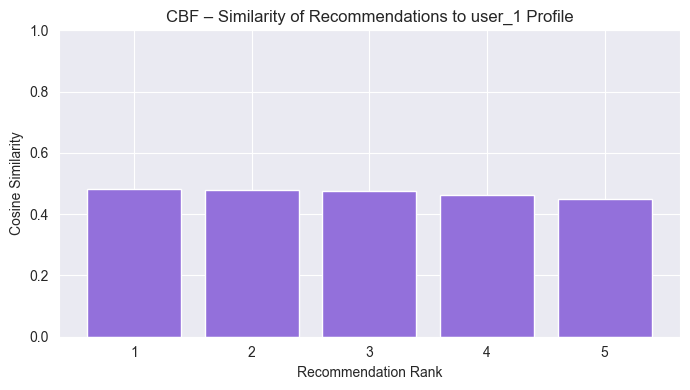

In [34]:
# Pick one sample user
sample_user = list(recommendations.keys())[0]
sample_recs = recommendations[sample_user]

liked_indices = [id_to_index[r] for r in simulated_users[sample_user] if r in id_to_index]
liked_vectors = ingredient_matrix[liked_indices].toarray()
user_profile_vector = liked_vectors.mean(axis=0, keepdims=True)

valid_indices = [id_to_index[r] for r in sample_recs if r in id_to_index]
rec_vectors = ingredient_matrix[valid_indices].toarray()

similarities = cosine_similarity(user_profile_vector, rec_vectors).flatten()

plt.figure(figsize=(7,4))
plt.bar(range(1, len(similarities)+1), similarities, color="mediumpurple")
plt.title(f"CBF – Similarity of Recommendations to {sample_user} Profile")
plt.xlabel("Recommendation Rank")
plt.ylabel("Cosine Similarity")
plt.ylim(0,1)
plt.tight_layout()
plt.show()


### Visualisation


### Step 11: Visualisation – Summary of Metrics

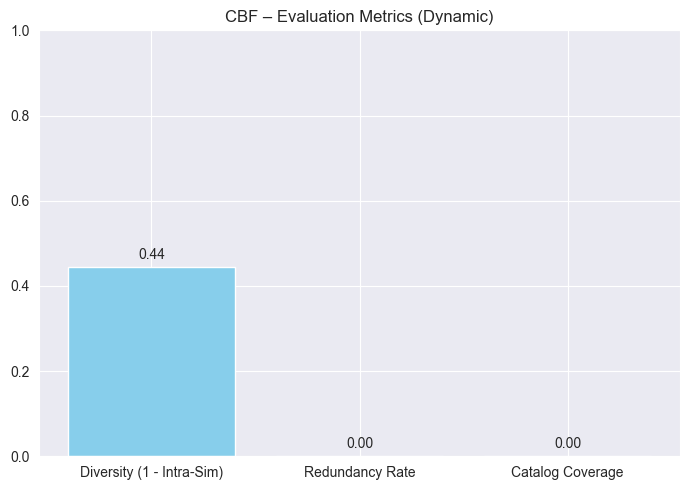

In [35]:
metrics = ['Diversity (1 - Intra-Sim)', 'Redundancy Rate', 'Catalog Coverage']
values = [diversity, redundancy_rate, coverage]

plt.figure(figsize=(7,5))
bars = plt.bar(metrics, values, color=['skyblue','orange','lightgreen'])
plt.title('CBF – Evaluation Metrics (Dynamic)')
plt.ylim(0,1)

for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f"{val:.2f}", ha="center")

plt.tight_layout()
plt.show()


### Coverage Pie Chart – CBF

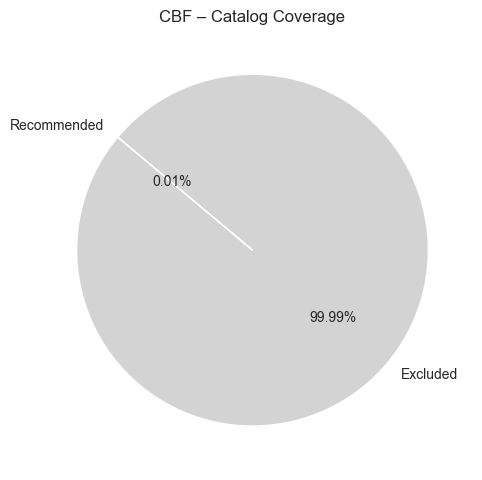

In [37]:
used = coverage
unused = 1 - used

plt.figure(figsize=(5, 5))
plt.pie([used, unused],
        labels=['Recommended', 'Excluded'],
        colors=['seagreen', 'lightgrey'],
        autopct='%1.2f%%',
        startangle=140)
plt.title('CBF – Catalog Coverage')
plt.tight_layout()
plt.show()
